train data: 122071518, validation data: test dataと同じ時間帯  
test supplement削除

In [1]:
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import gc
from contextlib import contextmanager

In [2]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')
    
def df_add_counts(df, cols):
    arr_slice = df[cols].values
    unq, unqtags, counts = np.unique(np.ravel_multi_index(arr_slice.T, arr_slice.max(axis=0) + 1),
                                     return_inverse=True, return_counts=True)
    df["_".join(cols)+'_count'] = counts[unqtags]
    
def make_count_features(df):
    with timer("add count features"):
        df['click_time']= pd.to_datetime(df['click_time'])
        dt= df['click_time'].dt
        df['day'] = dt.day.astype('uint8')
        df['hour'] = dt.hour.astype('uint8')
#         df['minute'] = dt.minute.astype('uint8')
#         df['second'] = dt.second.astype('uint8')#secondを追加

        del(dt)
        
        df_add_counts(df, ['ip'])
#         df_add_counts(df, ['ip','day','hour','minute'])
        df_add_counts(df, ['os','device'])
        df_add_counts(df, ['os','app','channel'])
        
        df_add_counts(df, ['ip', 'day', 'hour'])
        df_add_counts(df, ['ip', 'app'])
        df_add_counts(df, ['ip', 'app', 'os'])
        df_add_counts(df, ['ip', 'device'])
        df_add_counts(df, ['app', 'channel'])

def make_next_click_feature(df):
    with timer("Adding next click times"):
        D= 2**26
        df['category'] = (df['ip'].astype(str) + "_" + df['app'].astype(str) + "_" + df['device'].astype(str) \
                         + "_" + df['os'].astype(str)).apply(hash) % D
        click_buffer= np.full(D, 3000000000, dtype=np.uint32)
        df['epochtime']= df['click_time'].astype(np.int64) // 10 ** 9
        next_clicks= []
        for category, time in zip(reversed(df['category'].values), reversed(df['epochtime'].values)):
            next_clicks.append(click_buffer[category]-time)
            click_buffer[category]= time
        del(click_buffer)
        df['next_click']= list(reversed(next_clicks))
        
path = '~/talkingdata/input/'

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

columns = ['ip','app','device','os', 'channel', 'click_time', 'is_attributed']

In [3]:
with timer("load training data"):
    train_df = pd.read_csv(path+"train.csv",nrows=122071518, usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'], dtype=dtypes)

with timer("load test data"):
    test_df = pd.read_csv(path+"test.csv", dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])

[load training data] done in 105 s
[load test data] done in 16 s


In [4]:
# Validation data
print( "Extracting first chunk of validation data...")
valid1 = pd.read_csv( path+"/train.csv", 
                      skiprows=range(1,144708153), 
                      nrows=7705357, 
                      usecols=columns, 
                      dtype=dtypes)
print( "Extracting second chunk of validation data...")
valid2 = pd.read_csv( path+"/train.csv", 
                      skiprows=range(1,161974466), 
                      nrows=6291379, 
                      usecols=columns, 
                      dtype=dtypes)
valid2 = pd.concat([valid1, valid2])
del valid1
gc.collect()
print( "Extracting third chunk of validation data...")
valid3 = pd.read_csv( path+"/train.csv", 
                      skiprows=range(1,174976527), 
                      nrows=6901686, 
                      usecols=columns, 
                      dtype=dtypes)
valid3 = pd.concat([valid2,valid3])
del valid2
gc.collect()
valid_df = valid3
del valid3
gc.collect()

Extracting first chunk of validation data...
Extracting second chunk of validation data...
Extracting third chunk of validation data...


0

In [5]:
import pickle

with open('validation.csv.pkl','wb') as f:
  pickle.dump(valid_df, f, protocol=2)

In [6]:
num_train = train_df.shape[0]
num_valid = valid_df.shape[0]

y_train = train_df.is_attributed.values
y_val = valid_df.is_attributed.values

with open('y_train.csv.pkl','wb') as f:
  pickle.dump(y_train, f, protocol=2)

with open('y_val.csv.pkl','wb') as f:
  pickle.dump(y_val, f, protocol=2)

gc.collect()

sub = pd.DataFrame()
sub['click_id'] = test_df.click_id.values

common_column = ['ip','app','device','os','channel','click_time']
concat_df = pd.concat([train_df[common_column],valid_df[common_column],test_df[common_column]])

del train_df, valid_df, test_df
gc.collect()

135

In [7]:
make_count_features(concat_df)
make_next_click_feature(concat_df)

gc.collect()

[add count features] done in 881 s
[Adding next click times] done in 1335 s


28

In [9]:
train_df = concat_df.iloc[:num_train]
valid_test_df = concat_df.iloc[num_train:]

del concat_df
gc.collect()

val_df = valid_test_df.iloc[:num_valid]
test_df = valid_test_df.iloc[num_valid:]

del valid_test_df
gc.collect()

# with open('train_after.csv.pkl','wb') as f:
#   pickle.dump(train_df, f, protocol=2)

# with open('valid_after.csv.pkl','wb') as f:
#   pickle.dump(val_df, f, protocol=2)

# with open('test_after.csv.pkl','wb') as f:
#   pickle.dump(test_df, f, protocol=2)

NameError: name 'concat_df' is not defined

In [10]:
gc.collect()

252

In [11]:
# train_df, val_df, y_train, y_val = train_test_split(train_df, y, train_size=0.8, shuffle=False)#trainを0.8、シャッフルfalseにした

evals_results = {}
num_boost_round = 250
early_stopping_rounds = 30

In [12]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': 0,  # L1 regularization term on weights
    'reg_lambda': 0,  # L2 regularization term on weights
    'nthread': 12,
    'verbose': 0,
    'metric':'auc',     
 
    'learning_rate': 0.15,
    'num_leaves': 7,  # 2^max_depth - 1
    'max_depth': 3,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight':99
}
# metrics = 'auc'
# lgb_params = {
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     'metric': metrics,
#     'learning_rate': .1,
#     'num_leaves': 7,
#     'max_depth': 4,
#     'min_child_samples': 100,
#     'max_bin': 100,
#     'subsample': 0.7,
#     'subsample_freq': 1,
#     'colsample_bytree': 0.7,
#     'min_child_weight': 0,
#     'min_split_gain': 0,
#     'nthread': 4,
#     'verbose': 1,
#     'scale_pos_weight': 99.7
#     #'scale_pos_weight': 400
# }

In [13]:
target = "is_attributed"
categorical = ['app','os','channel','device','hour']
predictors = list(set(train_df.columns)-set([target])-set(['click_time','category','epochtime','day','ip']))
print(predictors)

print("preparing validation datasets")

xgtrain = lgb.Dataset(train_df[predictors].values,
                      label=y_train,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )

del train_df
del y_train
gc.collect()

xgvalid = lgb.Dataset(val_df[predictors].values,
                      label=y_val,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )

del val_df
del y_val
gc.collect()

['ip_app_os_count', 'os_app_channel_count', 'os_device_count', 'app_channel_count', 'ip_device_count', 'device', 'next_click', 'ip_count', 'os', 'hour', 'ip_day_hour_count', 'app', 'channel', 'ip_app_count']
preparing validation datasets


23

In [14]:
gc.collect()
booster = lgb.train(
     lgb_params, 
     xgtrain,
     valid_sets=[xgvalid],
     valid_names=['valid'],
     evals_result=evals_results, 
     num_boost_round=num_boost_round,
     early_stopping_rounds=early_stopping_rounds,
     verbose_eval=1
)

# n_estimators = model.best_iteration

# print('\nModel Info:')
# print('n_estimators:', n_estimators)
# print(metrics+':', evals_results['valid'][metrics][n_estimators-1])

del xgvalid
del xgtrain
gc.collect()

/home/um003580/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/um003580/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid's auc: 0.917973
Training until validation scores don't improve for 30 rounds.
[2]	valid's auc: 0.950555
[3]	valid's auc: 0.951297
[4]	valid's auc: 0.951581
[5]	valid's auc: 0.951883
[6]	valid's auc: 0.959265
[7]	valid's auc: 0.959193
[8]	valid's auc: 0.957971
[9]	valid's auc: 0.959095
[10]	valid's auc: 0.959696
[11]	valid's auc: 0.960345
[12]	valid's auc: 0.96358
[13]	valid's auc: 0.964921
[14]	valid's auc: 0.965021
[15]	valid's auc: 0.965778
[16]	valid's auc: 0.966675
[17]	valid's auc: 0.967733
[18]	valid's auc: 0.968267
[19]	valid's auc: 0.96849
[20]	valid's auc: 0.968549
[21]	valid's auc: 0.968824
[22]	valid's auc: 0.969206
[23]	valid's auc: 0.969456
[24]	valid's auc: 0.969675
[25]	valid's auc: 0.970144
[26]	valid's auc: 0.970753
[27]	valid's auc: 0.970802
[28]	valid's auc: 0.971279
[29]	valid's auc: 0.971791
[30]	valid's auc: 0.972516
[31]	valid's auc: 0.972692
[32]	valid's auc: 0.972893
[33]	valid's auc: 0.973358
[34]	valid's auc: 0.973683
[35]	valid's auc: 0.974068
[36]

32

[250]	valid's auc: 0.966742
Did not meet early stopping. Best iteration is:
[250]	valid's auc: 0.966742

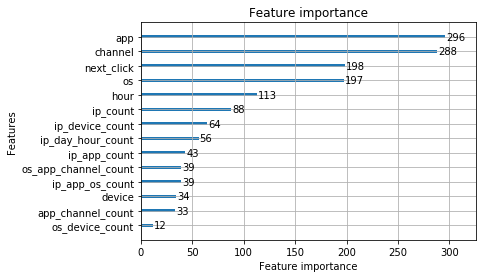

In [16]:
import matplotlib.pyplot as plt
ax = lgb.plot_importance(booster, max_num_features=100)
# plt.savefig('0501-1-1imp.png', dpi=600, bbox_inches='tight')
plt.show()

In [17]:
preditions=booster.predict(test_df[predictors].values)

In [18]:
sub['is_attributed']  = preditions

sub.to_csv('0501-1-1sub.csv', float_format='%.8f', index=False)